## BFCL

In [1]:
from unsloth import FastLanguageModel
import torch
model_name = "unsloth/Llama-3.2-1B-Instruct"
dtype = torch.bfloat16
load_in_4bit = False
model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=model_name,  # or choose "unsloth/Llama-3.2-1B"
        # max_seq_length = max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit,
        trust_remote_code=True,
    )

/home/recoverx/.cache/pypoetry/virtualenvs/finetuning-KL8mpKMW-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/recoverx/.cache/pypoetry/virtualenvs/finetuning-KL8mpKMW-py3.10/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2024.10.7: Fast Llama patching. Transformers = 4.46.1.
   \\   /|    GPU: NVIDIA A100 80GB PCIe. Max memory: 79.325 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [2]:
import json
from datasets import Dataset
import functools
import finetune

train_data = []
with open("train.json", "r") as file:
    for line in file:
        json_obj = json.loads(line.strip())
        json_obj["Functions"] = (
            json_obj["Functions"][0]
            if isinstance(json_obj["Functions"], list)
            else json_obj["Functions"]
        )
        json_obj["Output"] = (
            json_obj["Output"][0]
            if isinstance(json_obj["Output"], list)
            else json_obj["Output"]
        )
        train_data.append(json_obj)

with open("test.json", "r") as file:
    test_data = json.load(file)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: athe_kunal (ad-finance). Use `wandb login --relogin` to force relogin


In [25]:
def get_bfcl_ds(json_or_yaml)->tuple[list[int],list[int]]:
    train_ds = Dataset.from_list(train_data)
    train_ds = train_ds.map(
        functools.partial(
            finetune._get_bfcl_train_tokenized_ds,
            tokenizer=tokenizer,
            json_or_yaml=json_or_yaml,
        ),
        batched=True,
    )
    test_ds = Dataset.from_list(test_data)
    test_ds = test_ds.map(
        functools.partial(
            finetune._get_bfcl_tokenized_test_ds,
            tokenizer=tokenizer,
            json_or_yaml=json_or_yaml,
        ),
        batched=True,
        remove_columns=["function", "question"],
    )
    num_train_tokens, num_test_tokens = get_token_length(train_ds, tokenizer), get_token_length(test_ds, tokenizer)
    return num_train_tokens, num_test_tokens

def get_token_length(ds,tokenizer):
    tokens = tokenizer(ds['prompt'])
    return [len(token) for token in tokens['input_ids']]

In [52]:
num_train_tokens_json_bfcl, num_test_tokens_json_bfcl = get_bfcl_ds("json")
num_train_tokens_yaml_bfcl, num_test_tokens_yaml_bfcl = get_bfcl_ds("yaml")

Map: 100%|██████████| 112/112 [00:00<00:00, 149.14 examples/s]


In [43]:
from scipy import stats
import numpy as np

def compare_token_lengths(tokens_json, tokens_yaml):
    # Perform independent t-test
    t_stat, p_value = stats.ttest_ind(tokens_json, tokens_yaml)

    print("Statistical comparison of JSON vs YAML token lengths:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

    # Calculate and print means
    json_mean = np.mean(tokens_json)
    yaml_mean = np.mean(tokens_yaml)
    print(f"\nMean token length:")
    print(f"JSON: {json_mean:.2f}")
    print(f"YAML: {yaml_mean:.2f}")
    print(f"Difference (JSON - YAML): {json_mean - yaml_mean:.2f}")
    print(f"p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("\nThe difference is statistically significant (p < 0.05)")
        print(f"{'JSON' if json_mean > yaml_mean else 'YAML'} has significantly longer token lengths")
    else:
        print("\nThe difference is not statistically significant (p >= 0.05)")


In [44]:
compare_token_lengths(num_train_tokens_json, num_train_tokens_yaml)

Statistical comparison of JSON vs YAML token lengths:
t-statistic: 14.4269
p-value: 0.0000

Mean token length:
JSON: 384.17
YAML: 355.59
Difference (JSON - YAML): 28.59
p-value: 0.0000

The difference is statistically significant (p < 0.05)
JSON has significantly longer token lengths


In [45]:
compare_token_lengths(num_test_tokens_json, num_test_tokens_yaml)

Statistical comparison of JSON vs YAML token lengths:
t-statistic: 15.5370
p-value: 0.0000

Mean token length:
JSON: 1084.04
YAML: 918.03
Difference (JSON - YAML): 166.02
p-value: 0.0000

The difference is statistically significant (p < 0.05)
JSON has significantly longer token lengths


## XLAM

In [53]:
from datasets import DatasetDict


def get_xlam_ds(json_or_yaml)->tuple[Dataset,Dataset]:
    ds = DatasetDict.load_from_disk(f"xlam_data_{json_or_yaml}")['train']
    split_ds = ds.train_test_split(test_size=1000,seed=42)
    train_ds = split_ds['train']
    test_ds = split_ds['test']
    return train_ds, test_ds

train_ds, test_ds = get_xlam_ds("json")
num_train_tokens_json_xlam, num_test_tokens_json_xlam = get_token_length(train_ds, tokenizer), get_token_length(test_ds, tokenizer)

In [54]:
train_ds_yaml, test_ds_yaml = get_xlam_ds("yaml")
num_train_tokens_yaml_xlam, num_test_tokens_yaml_xlam = get_token_length(train_ds_yaml, tokenizer), get_token_length(test_ds_yaml, tokenizer)

In [50]:
compare_token_lengths(num_train_tokens_json, num_train_tokens_yaml)

Statistical comparison of JSON vs YAML token lengths:
t-statistic: 67.3768
p-value: 0.0000

Mean token length:
JSON: 555.81
YAML: 467.99
Difference (JSON - YAML): 87.82
p-value: 0.0000

The difference is statistically significant (p < 0.05)
JSON has significantly longer token lengths


In [51]:
compare_token_lengths(num_test_tokens_json, num_test_tokens_yaml)

Statistical comparison of JSON vs YAML token lengths:
t-statistic: 8.8895
p-value: 0.0000

Mean token length:
JSON: 566.46
YAML: 475.61
Difference (JSON - YAML): 90.85
p-value: 0.0000

The difference is statistically significant (p < 0.05)
JSON has significantly longer token lengths


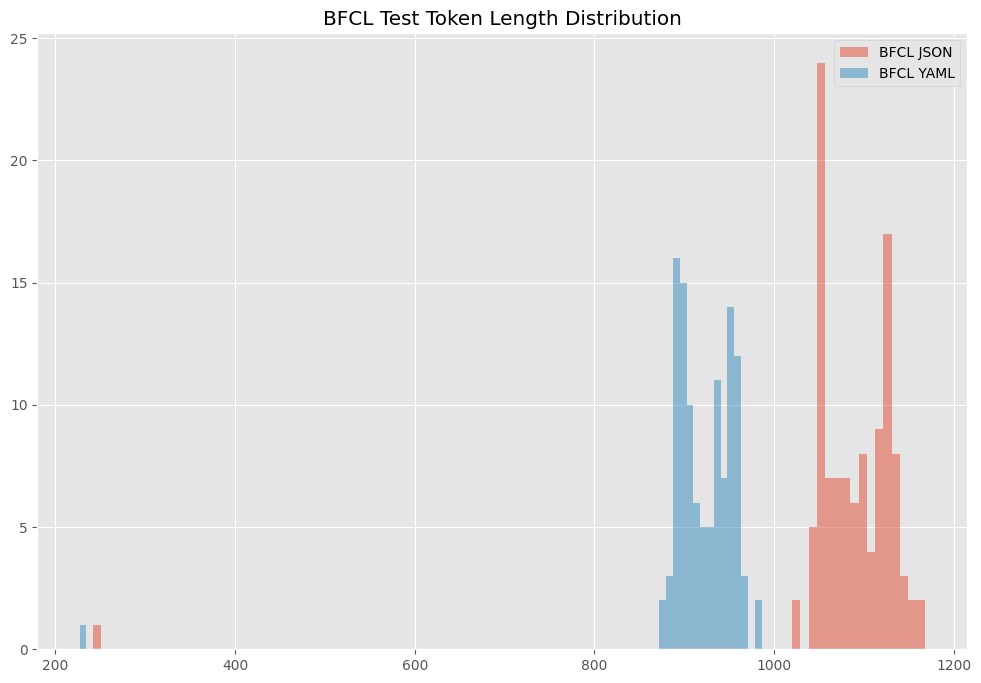

In [56]:
#plot num_train_tokens_json, num_train_tokens_yaml as a normal distribution
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.hist(num_test_tokens_json_bfcl, bins=100, alpha=0.5, label='BFCL JSON')
plt.hist(num_test_tokens_yaml_bfcl, bins=100, alpha=0.5, label='BFCL YAML')
plt.legend(loc='upper right')
plt.title('BFCL Test Token Length Distribution')
plt.show()

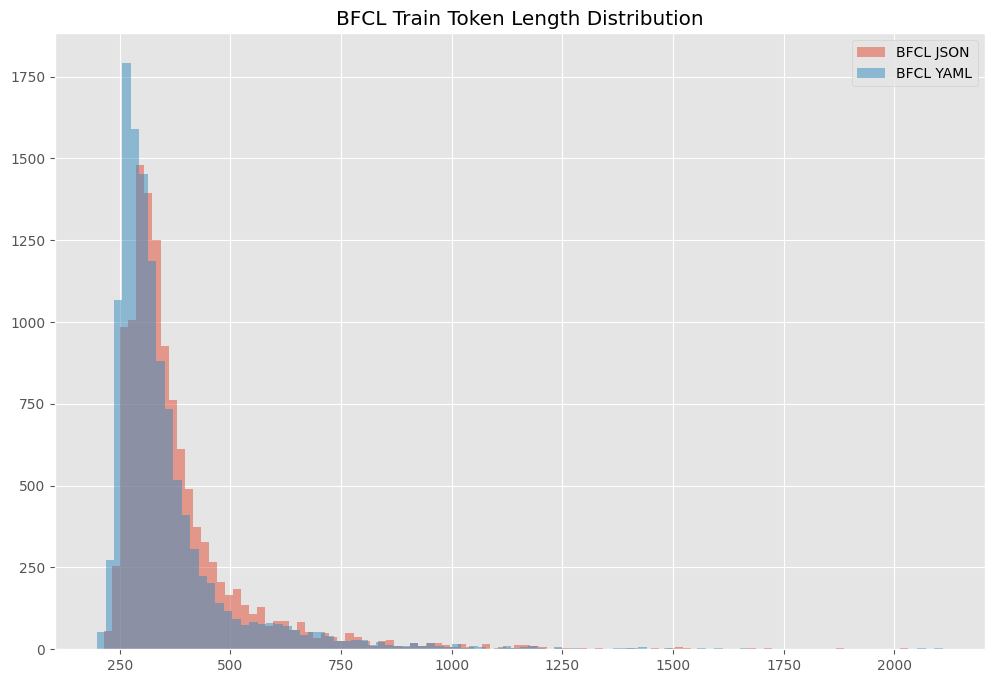

In [57]:
#plot num_train_tokens_json, num_train_tokens_yaml as a normal distribution
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.hist(num_train_tokens_json_bfcl, bins=100, alpha=0.5, label='BFCL JSON')
plt.hist(num_train_tokens_yaml_bfcl, bins=100, alpha=0.5, label='BFCL YAML')
plt.legend(loc='upper right')
plt.title('BFCL Train Token Length Distribution')
plt.show()

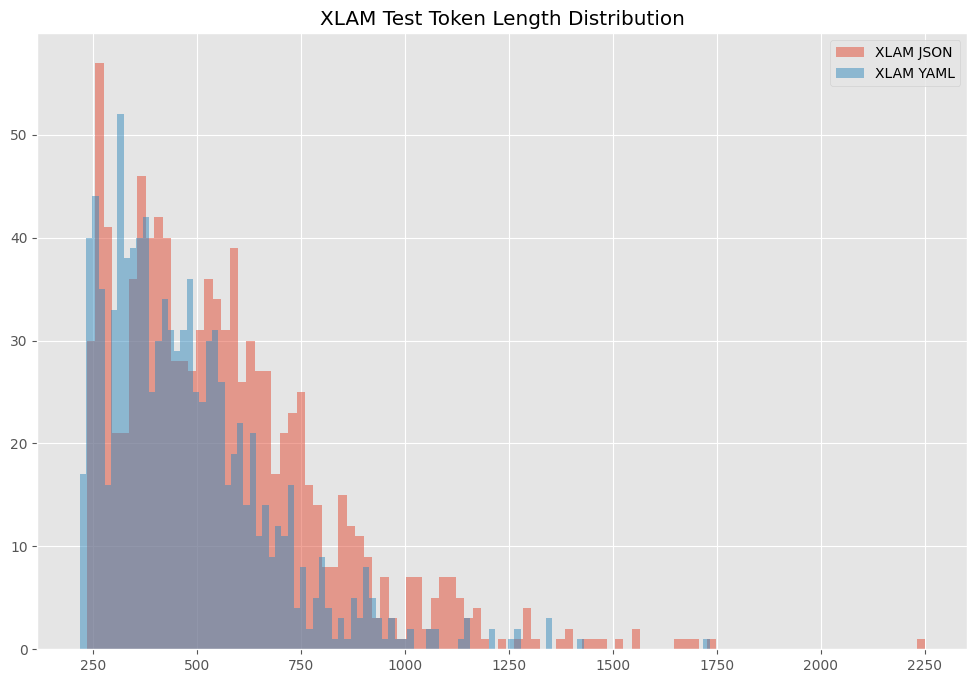

In [58]:
#plot num_train_tokens_json, num_train_tokens_yaml as a normal distribution
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.hist(num_test_tokens_json_xlam, bins=100, alpha=0.5, label='XLAM JSON')
plt.hist(num_test_tokens_yaml_xlam, bins=100, alpha=0.5, label='XLAM YAML')
plt.legend(loc='upper right')
plt.title('XLAM Test Token Length Distribution')
plt.show()

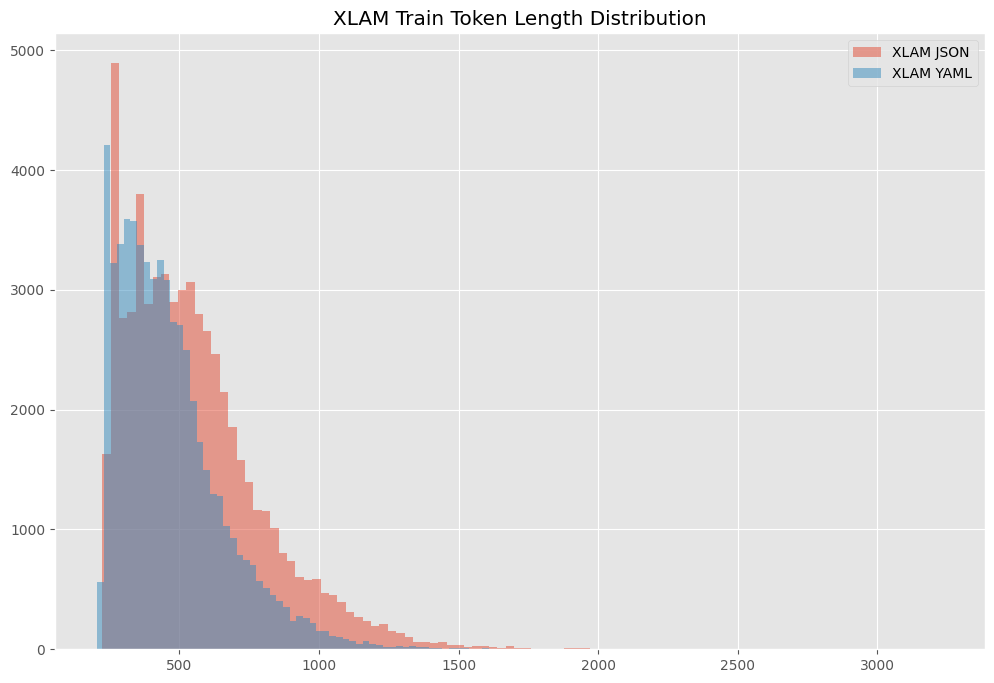

In [59]:
#plot num_train_tokens_json, num_train_tokens_yaml as a normal distribution
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
plt.hist(num_train_tokens_json_xlam, bins=100, alpha=0.5, label='XLAM JSON')
plt.hist(num_train_tokens_yaml_xlam, bins=100, alpha=0.5, label='XLAM YAML')
plt.legend(loc='upper right')
plt.title('XLAM Train Token Length Distribution')
plt.show()